In [76]:
# initial check value
import pandas as pd
import numpy as np
import cv2
from scipy.spatial.transform import Rotation as R

data = np.load('/home/choigh/WS/CR_SF_PJT/src/01_CR_PJT/cr_test/t_rvec_ee_list/t_rvec_ee_list.npz')

tvecs = data['tvecs']   # [count, id, tx, ty, tz]
rvecs = data['rvecs']   # [count, rx, ry, rz]
ee_pose = data['ee_pose']  # [x, y, z, roll, pitch, yaw]

eyehand_data = pd.DataFrame({
    'count': tvecs[:, 0].astype(int),
    'id': tvecs[:, 1].astype(int),
    'tvec_x': tvecs[:, 2],
    'tvec_y': tvecs[:, 3],
    'tvec_z': tvecs[:, 4],
    'rvec_x': rvecs[:, 1],
    'rvec_y': rvecs[:, 2],
    'rvec_z': rvecs[:, 3],
    'ee_x': ee_pose[:, 0],
    'ee_y': ee_pose[:, 1],
    'ee_z': ee_pose[:, 2],
    'ee_roll': ee_pose[:, 3],
    'ee_pitch': ee_pose[:, 4],
    'ee_yaw': ee_pose[:, 5],
})

# --- 카메라 → 마커 (target → camera) ---
R_target2cam = []
t_target2cam = []

for _, row in eyehand_data.iterrows():
    rvec = np.array([row['rvec_x'], row['rvec_y'], row['rvec_z']], dtype=float)
    tvec = np.array([[row['tvec_x']], [row['tvec_y']], [row['tvec_z']]])
    Rm, _ = cv2.Rodrigues(rvec)
    R_target2cam.append(Rm)
    t_target2cam.append(tvec)


# --- 로봇 EE → Base (gripper → base) ---
R_gripper2base = []
t_gripper2base = []

for _, row in eyehand_data.iterrows():
    # ZYX 순서 (yaw, pitch, roll)
    Rm = R.from_euler('zyx',
                      [row['ee_yaw'], row['ee_pitch'], row['ee_roll']],
                      degrees=False).as_matrix()
    tvec = np.array([[row['ee_x']], [row['ee_y']], [row['ee_z']]])
    R_gripper2base.append(Rm)
    t_gripper2base.append(tvec)

# --- Hand-Eye Calibration ---
R_cam2gripper, t_cam2gripper = cv2.calibrateHandEye(
    R_gripper2base, t_gripper2base,
    R_target2cam, t_target2cam,
    method=cv2.CALIB_HAND_EYE_TSAI
)
# (선택) Euler로 변환해서 보기
euler = R.from_matrix(R_cam2gripper).as_euler('zyx', degrees=True)

# --- 결과 출력 ---
print("===== Hand-Eye Calibration Result =====")
print("R_cam2gripper:\n", R_cam2gripper)
print("t_cam2gripper [m]:\n", f"x(cm): {t_cam2gripper[0]}", f"y(cm): {t_cam2gripper[1]}", f"z(cm): {t_cam2gripper[2]}")
print("Euler angles [deg] (yaw, pitch, roll):", euler)

===== Hand-Eye Calibration Result =====
R_cam2gripper:
 [[ 0.05161824  0.0687529   0.99629744]
 [-0.99834613 -0.02173037  0.05322396]
 [ 0.02530921 -0.99739703  0.06751751]]
t_cam2gripper [m]:
 x(cm): [-0.13781677] y(cm): [0.06666444] z(cm): [0.05343585]
Euler angles [deg] (yaw, pitch, roll): [-53.10154579  85.06800566 -38.24866319]


In [41]:
import numpy as np
import pandas as pd
data = np.load('/home/choigh/WS/CR_SF_PJT/src/01_CR_PJT/cr_test/t_rvec_ee_list/t_rvec_ee_list.npz')


# 배열 불러오기
tvecs = data['tvecs']
rvecs = data['rvecs']
ee_pose = data['ee_pose']

eyehand_data = pd.DataFrame({
    'count': tvecs[:, 0].astype(int),
    'id': tvecs[:, 1].astype(int),
    'tvec_x': tvecs[:, 2],
    'tvec_y': tvecs[:, 3],
    'tvec_z': tvecs[:, 4],
    'rvec_x': rvecs[:, 1],
    'rvec_y': rvecs[:, 2],
    'rvec_z': rvecs[:, 3],
    'ee_x': ee_pose[:, 0],
    'ee_y': ee_pose[:, 1],
    'ee_z': ee_pose[:, 2],
    'ee_roll': ee_pose[:, 3],
    'ee_pitch': ee_pose[:, 4],
    'ee_yaw': ee_pose[:, 5],
})
print(eyehand_data.head())

   count  id    tvec_x    tvec_y    tvec_z    rvec_x    rvec_y    rvec_z  \
0      1   1 -0.030191  0.005181  0.271293  3.045040  0.012164  0.074951   
1      2   2  0.066678 -0.011672  0.288607  2.919430 -0.013363 -0.520651   
2      3   1 -0.050449  0.008574  0.271564  3.033524 -0.006457  0.169096   
3      4   2  0.045231 -0.008821  0.293332  2.928265 -0.035522 -0.411057   
4      5   1  0.027991  0.025866  0.276980  2.961319  0.050748 -0.211026   

       ee_x      ee_y      ee_z       ee_roll  ee_pitch    ee_yaw  
0  0.132121 -0.004055  0.240132  2.182203e-18  0.112516 -0.033748  
1  0.132121 -0.004055  0.240132  2.182203e-18  0.112516 -0.033748  
2  0.131313 -0.010090  0.241442 -3.489170e-18  0.106377 -0.084369  
3  0.131313 -0.010090  0.241442 -3.489170e-18  0.106377 -0.084369  
4  0.127725  0.016268  0.249240  9.564098e-18  0.069544  0.139660  


In [49]:
eyehand_data = eyehand_data[eyehand_data['id']==1]

/tmp/ipykernel_8232/2355709261.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([tx, ty, tz, rx, ry, rz], labels=['tx', 'ty', 'tz','rx', 'ry', 'rz'])


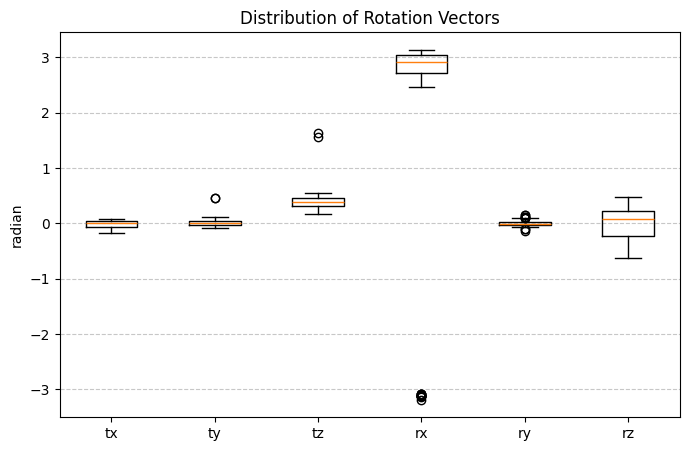

In [50]:
import matplotlib.pyplot as plt
import numpy as np

tx = tvecs[:, 2]
ty = tvecs[:, 3]
tz = tvecs[:, 4]
rx = rvecs[:, 1]
ry = rvecs[:, 2]
rz = rvecs[:, 3]

# boxplot 생성
plt.figure(figsize=(8, 5))
plt.boxplot([tx, ty, tz, rx, ry, rz], labels=['tx', 'ty', 'tz','rx', 'ry', 'rz'])
plt.title('Distribution of Rotation Vectors')
plt.ylabel('radian')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

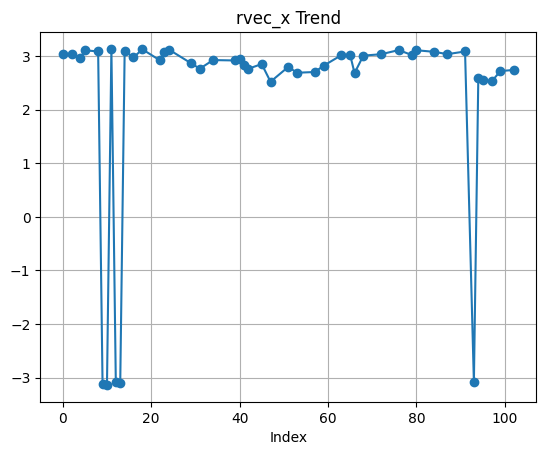

In [64]:
name = 'rvec_x'
eyehand_data[f'{name}']

plt.plot(eyehand_data[f'{name}'], marker='o')
plt.title(f'{name} Trend')
plt.xlabel('Index')
plt.grid(True)
plt.show()


In [69]:
ty_outlier = (eyehand_data['tvec_y'] > 0.2).sum()
tz_outlier = (eyehand_data['tvec_z'] > 0.6).sum()
rx_outlier = (eyehand_data['rvec_x'] < 0).sum()
print(f"ty: {ty_outlier}", f"tz: {tz_outlier}", f"rx: {rx_outlier}")

ty: 2 tz: 2 rx: 5


In [ ]:
ty_outliers = eyehand_data.loc[eyehand_data['tvec_y'] > 0.2, 'count']
tz_outliers = eyehand_data.loc[eyehand_data['tvec_z'] > 0.6, 'count']
rx_outliers = eyehand_data.loc[eyehand_data['rvec_x'] < 0, 'count']

print("ty outliers:", list(ty_outliers))
print("tz outliers:", list(tz_outliers))
print("rx outliers:", list(rx_outliers))


ty outliers: [41, 67]
tz outliers: [41, 67]
rx outliers: [10, 11, 13, 14, 94]


In [ ]:
# 1️⃣ id == 1 인 데이터만 필터링
eyehand_refined = eyehand_data[eyehand_data['id'] == 1].copy()

# 2️⃣ 튀는값(outlier) 제거 조건 설정
ty_outlier = eyehand_data['tvec_y'] <= 0.2
tz_outlier = eyehand_data['tvec_z'] <= 0.6
rx_outlier = eyehand_data['rvec_x'] >= 0

# 3️⃣ 세 조건 모두 만족하는 행만 남기기
eyehand_refined = eyehand_refined[ty_outlier & tz_outlier & rx_outlier]

# 4️⃣ 결과 확인
print("✅ Refined data shape:", eyehand_refined.shape)
print(eyehand_refined.head())

✅ Refined data shape: (39, 14)
   count  id    tvec_x    tvec_y    tvec_z    rvec_x    rvec_y    rvec_z  \
0      1   1 -0.030191  0.005181  0.271293  3.045040  0.012164  0.074951   
2      3   1 -0.050449  0.008574  0.271564  3.033524 -0.006457  0.169096   
4      5   1  0.027991  0.025866  0.276980  2.961319  0.050748 -0.211026   
5      6   1 -0.053930 -0.026356  0.264337  3.105720 -0.009680  0.188243   
8      9   1  0.046301 -0.033225  0.262675  3.087429  0.092803 -0.247809   

       ee_x      ee_y      ee_z       ee_roll  ee_pitch    ee_yaw  
0  0.132121 -0.004055  0.240132  2.182203e-18  0.112516 -0.033748  
2  0.131313 -0.010090  0.241442 -3.489170e-18  0.106377 -0.084369  
4  0.127725  0.016268  0.249240  9.564098e-18  0.069544  0.139660  
5  0.129757 -0.011051  0.223726 -1.057939e-17  0.180067 -0.093573  
8  0.126115  0.021620  0.217435 -3.534642e-18  0.192362  0.187237  


/tmp/ipykernel_8232/3882979229.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([tx, ty, tz, rx, ry, rz], labels=['tx', 'ty', 'tz','rx', 'ry', 'rz'])


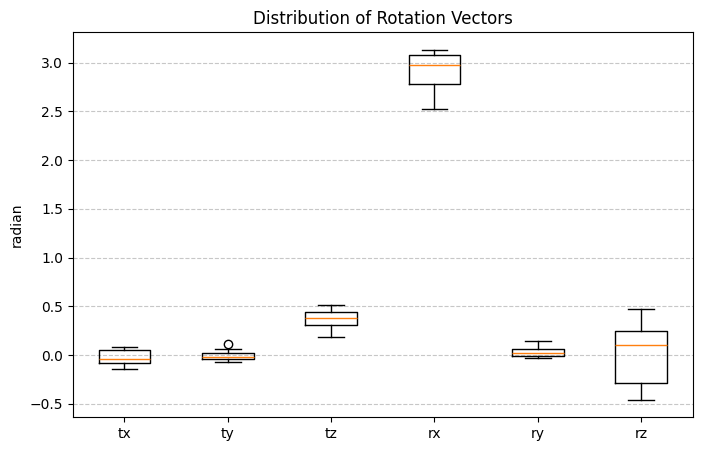

In [77]:
import matplotlib.pyplot as plt
import numpy as np

tx = eyehand_refined['tvec_x']
ty = eyehand_refined['tvec_y']
tz = eyehand_refined['tvec_z']
rx = eyehand_refined['rvec_x']
ry = eyehand_refined['rvec_y']
rz = eyehand_refined['rvec_z']

# boxplot 생성
plt.figure(figsize=(8, 5))
plt.boxplot([tx, ty, tz, rx, ry, rz], labels=['tx', 'ty', 'tz','rx', 'ry', 'rz'])
plt.title('Distribution of Rotation Vectors')
plt.ylabel('radian')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

In [78]:
# Finally refined value
import pandas as pd
import numpy as np
import cv2
from scipy.spatial.transform import Rotation as R

# --- 카메라 → 마커 (target → camera) ---
R_target2cam = []
t_target2cam = []

for _, row in eyehand_refined.iterrows():
    rvec = np.array([row['rvec_x'], row['rvec_y'], row['rvec_z']], dtype=float)
    tvec = np.array([[row['tvec_x']], [row['tvec_y']], [row['tvec_z']]])
    Rm, _ = cv2.Rodrigues(rvec)
    R_target2cam.append(Rm)
    t_target2cam.append(tvec)


# --- 로봇 EE → Base (gripper → base) ---
R_gripper2base = []
t_gripper2base = []

for _, row in eyehand_refined.iterrows():
    # ZYX 순서 (yaw, pitch, roll)
    Rm = R.from_euler('zyx',
                      [row['ee_yaw'], row['ee_pitch'], row['ee_roll']],
                      degrees=False).as_matrix()
    tvec = np.array([[row['ee_x']], [row['ee_y']], [row['ee_z']]])
    R_gripper2base.append(Rm)
    t_gripper2base.append(tvec)

# --- Hand-Eye Calibration ---
R_cam2gripper, t_cam2gripper = cv2.calibrateHandEye(
    R_gripper2base, t_gripper2base,
    R_target2cam, t_target2cam,
    method=cv2.CALIB_HAND_EYE_TSAI
)
# (선택) Euler로 변환해서 보기
euler = R.from_matrix(R_cam2gripper).as_euler('zyx', degrees=True)

# --- 결과 출력 ---
print("===== Hand-Eye Calibration Result : data refined =====")
print("R_cam2gripper:\n", R_cam2gripper)
print("t_cam2gripper [m]:\n", f"x(cm): {t_cam2gripper[0]*100}", f"y(cm): {t_cam2gripper[1]*100}", f"z(cm): {t_cam2gripper[2]*100}")
print("Euler angles [deg] (yaw, pitch, roll):", euler)

===== Hand-Eye Calibration Result : data refined =====
R_cam2gripper:
 [[-0.06043361 -0.01568252  0.99804902]
 [-0.99776994 -0.02743505 -0.06084781]
 [ 0.02833577 -0.99950056 -0.01398955]]
t_cam2gripper [m]:
 x(cm): [-6.82329904] y(cm): [-1.53907802] z(cm): [5.93800608]
Euler angles [deg] (yaw, pitch, roll): [165.45261957  86.42039414 102.94789638]
